## Replicating Igami and Sugaya (2021) - Analysis of Collusion in Global Vitamin C Market

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = pd.read_csv('problem_set_2_data.csv')
df.head(6)

,year,I_cartel,P,Q,q_basf,q_emerck,q_roche,q_takeda,q_fri
0,1980,0,10.932500,2.68177,0.00000,0.34863,1.36770,0.48272,0.48272
1,1981,0,11.659167,2.89156,0.00000,0.34699,1.56144,0.52048,0.46265
2,1982,0,11.310000,2.73986,0.13699,0.32878,1.47953,0.52057,0.27399
3,1983,0,10.857500,2.88158,0.14408,0.31697,1.52724,0.54750,0.34579
4,1984,0,10.525000,2.95320,0.20672,0.35438,1.62426,0.53158,0.23626
5,1985,1,9.956667,2.94722,0.14736,0.35367,1.62097,0.53050,0.29472


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Data Description

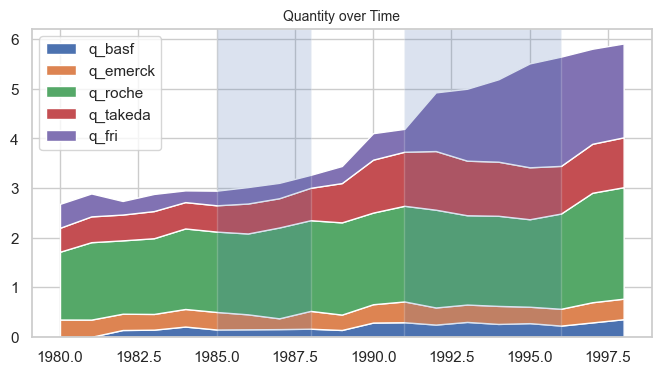

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['figure.titlesize'] = 59
plt.rcParams['axes.titlesize'] = 10

def plot(names, title, stack = False):
    if stack == True:
        y = np.vstack([df.q_basf, df.q_emerck, df.q_roche,df.q_takeda, df.q_fri])
        plt.stackplot(df.year.astype(int), y, labels=names)
    else:
        plt.plot(df.year,df[names], label = names)
    plt.legend(loc='upper left')
    plt.axvspan(1985, 1988, alpha=0.2)
    plt.axvspan(1991, 1996, alpha=0.2)
    plt.title(title)
    plt.show()
 
plot(['q_basf','q_emerck','q_roche','q_takeda','q_fri'], 'Quantity over Time', stack=True)

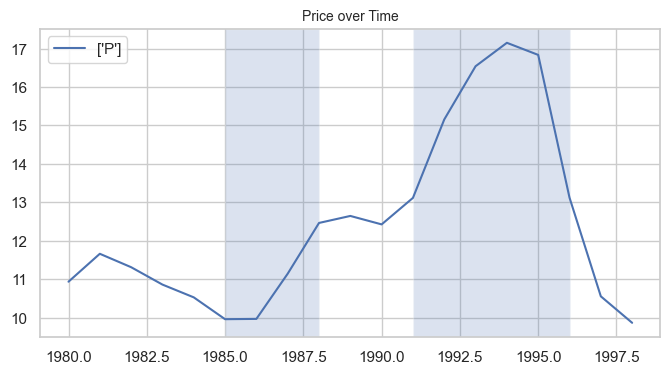

In [4]:
plot(['P'], 'Price over Time')

### Calibration

(2) 
- Market demand: $Q^D = \alpha_1 P + \epsilon$
- Demand net of fringe supply: $Q^C = Q^D - Q^F$
- Firms: $i \in \{R,T,E,B\}$
- Cost function: $c(q) = \bar{c}_i q$
- Firm i problem: $\pi_i = \max_{q_i \geq 0} q_i P - \bar{c}_i q_i$
- FOC for firm i: $q_i=-\alpha_1(P-\bar{c}_i)$

(3) Calibrating alpha

- FOC for firm i: $-q_i/(P-\bar{c}_i)=\alpha_1$
- FOC for firm i in period t: $-q_{i,t}/(P_{t}-\bar{c}_i)=\alpha_{1,t}$
- $\bar{\alpha}_{1}= T^{-1} \sum_t \alpha_{1,t}$



In [5]:
def calibrateAlpha(years, name, c_):
    alphas = []
    Ps = list(df.P[df.year.isin(years)])
    qs = list(df[name][df.year.isin(years)])    
    for t in range(len(years)):
        alphas.append(-qs[t]/(Ps[t]-c_))
    return np.mean(alphas)

years = [1980,1981,1982,1983,1984]
alpha = calibrateAlpha(years, 'q_roche', 5.9)
print(alpha)

-0.29512690786553064


(3) Calibrating marginal costs

- FOC for firm i: $\bar{c}_{i,t} = \frac{q_{i,t}+\alpha_1 P_{t}}{\alpha_1}$
- $\bar{c}_{i}= T^{-1} \sum_t \bar{c}_{i,t}$



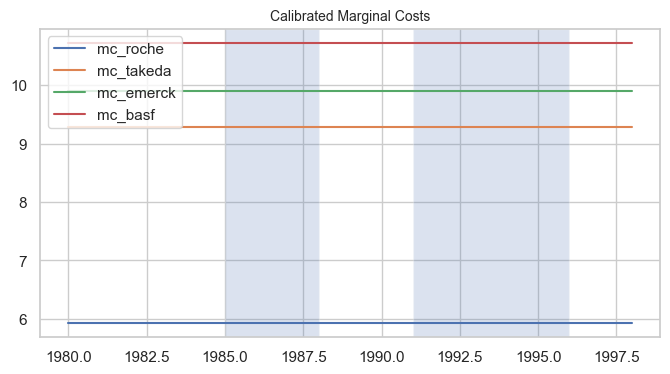

In [6]:
def calculateMC(alpha, years, name):
    cs = []
    Ps = list(df.P[df.year.isin(years)])
    name = 'q_' + str(name)
    qs = list(df[name][df.year.isin(years)])
    for t in range(len(years)):
        cs.append((qs[t]+alpha*Ps[t])/alpha)
    c = np.mean(cs)
    return np.ones(df.shape[0])*c
 
df['mc_roche'] = calculateMC(alpha, years, 'roche')
df['mc_takeda'] = calculateMC(alpha, years, 'takeda')
df['mc_emerck'] = calculateMC(alpha, years, 'emerck')
df['mc_basf'] = calculateMC(alpha,years, 'basf')
plot(['mc_roche','mc_takeda','mc_emerck','mc_basf'], 'Calibrated Marginal Costs')

(5) Demand shifter

- Market demand: $Q^D = \alpha_1 P + \epsilon$
- Market demand: $Q^D - \alpha_1 P = \epsilon$



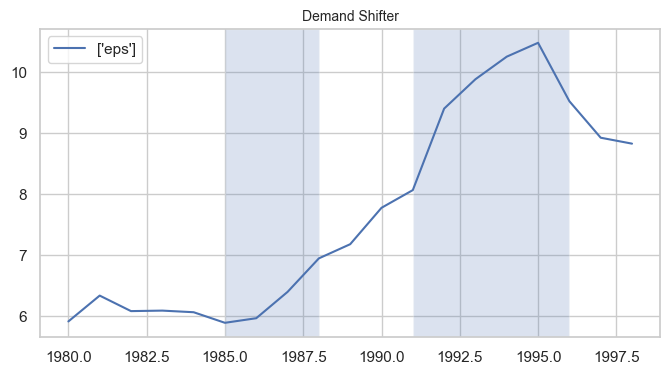

In [7]:
df['eps'] = df.Q - alpha * df.P
plot(['eps'], 'Demand Shifter')

(6) Merger Simulation

- if all 4 firms were to merge, then optimization equation is:
- At period t, $\pi = \max P(q_1 + q_2 + q_3 + q_4) - (c_1 q_1 + c_2 q_2 + c_3 q_3 + c_4 q_4)$
- subject to, $P = (1/\alpha) * (q_1 + q_2 + q_3 + q_4 + q_f - \epsilon)$
- Without capacity constraints, Monopoly would only produce with lowest cost firm - i.e. Roche
- At period t, $\pi = \max P q - c q$
- FOC: $P  + (1/alpha) * (q+q_f) - c = 0$
- Solution: $q_m = 0.5 (\epsilon + \alpha * c  - q_f)$
- Solution: $P_m = c - (1/\alpha) * q_m$






In [8]:
# Monopoly price and quantity
df['q_m'] = 0.5 * (df.eps + alpha * df.mc_roche - df.q_fri)
df['p_m'] = 1/alpha * (df.q_m+df.q_fri-df.eps)
df.head(1)

,year,I_cartel,P,Q,q_basf,q_emerck,q_roche,q_takeda,q_fri,mc_roche,mc_takeda,mc_emerck,mc_basf,eps,q_m,p_m
0,1980,0,10.9325,2.68177,0.0,0.34863,1.3677,0.48272,0.48272,5.933498,9.292948,9.907667,10.72627,5.908245,1.837195,12.1586


In [9]:
def computeCournot(x):
    B1 = alpha * x.mc_basf + x.eps - x.q_fri
    B2 = alpha * x.mc_roche + x.eps - x.q_fri
    B3 = alpha * x.mc_takeda + x.eps - x.q_fri
    B4 = alpha * x.mc_emerck + x.eps - x.q_fri
    B = np.array([B1,B2,B3,B4])
    A = np.array([[2,1,1,1],[1,2,1,1],[1,1,2,1],[1,1,1,2]])
    Q = np.dot(np.linalg.inv(A),B)
    return list(Q)

df[['q_c_basf', 'q_c_roche', 'q_c_takeda','q_c_emerck']] = df.apply(computeCournot, result_type='expand', axis = 1)
df['q_c'] = df['q_c_basf']+df['q_c_roche']+df['q_c_takeda']+df['q_c_emerck']
df['p_c'] = (1/alpha)*(df['q_c']+df['q_fri']-df['eps'])
df['Q_wo_fri'] = df['Q']-df['q_fri']

def computeProfits(title, out=False):
    for name in ['basf','roche','takeda','emerck']:
        pi = 'pi_'+title+'_'+name
        q = 'q_'+title+'_'+name
        p = 'p_'+title
        c = 'mc_'+name
        if out==True:
            return (df[p]-df[c])*df[q]
        else:
            df[pi] = (df[p]-df[c])*df[q]
        
computeProfits('c')

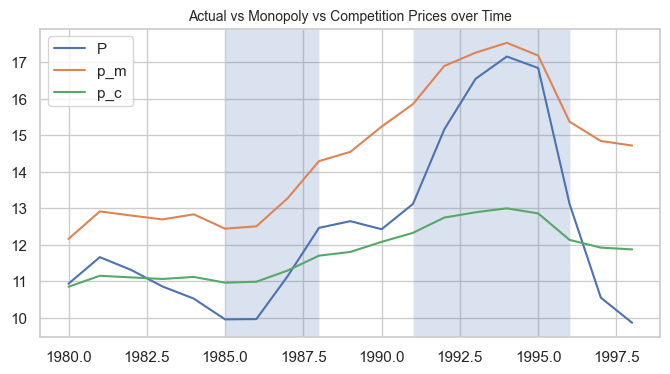

In [10]:
plot(['P','p_m','p_c'], 'Actual vs Monopoly vs Competition Prices over Time')

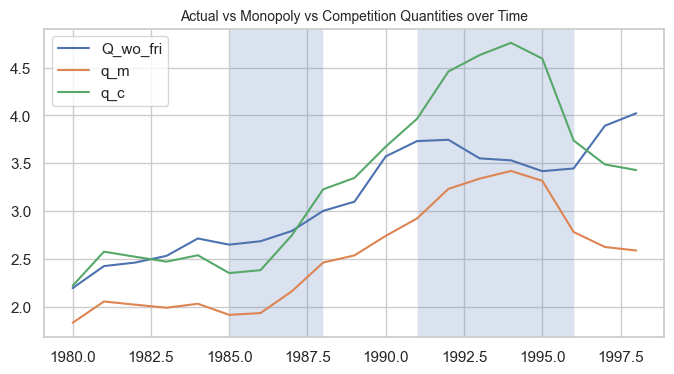

In [11]:
plot(['Q_wo_fri','q_m','q_c'], 'Actual vs Monopoly vs Competition Quantities over Time')

### Collusion

(7) Roche as cartel leader

- with shares fixed to pre 1990 levels, Roche is effectively choosing total cartel quantity (as it is also min cost producer)
- this is same as monopoly output
- prices will be monopoly prices

#### (8a) Cartel

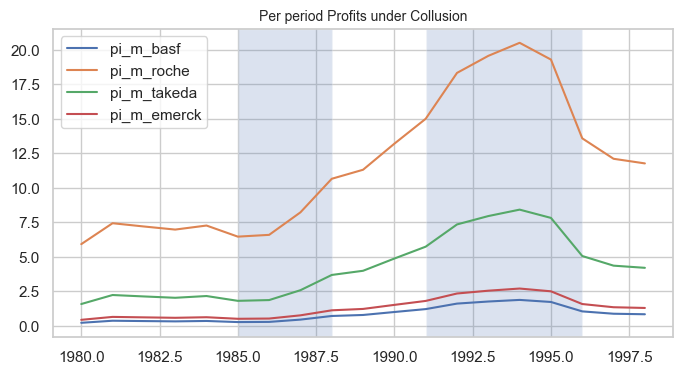

In [12]:
df1990 = df[df.year.isin([1990])]

# profits under collusion
df['sh_basf'] = float(df1990.q_basf/(df1990.Q-df1990.q_fri))
df['sh_roche'] = float(df1990.q_roche/(df1990.Q-df1990.q_fri))
df['sh_takeda'] = float(df1990.q_takeda/(df1990.Q-df1990.q_fri))
df['sh_emerck'] = float(df1990.q_emerck/(df1990.Q-df1990.q_fri))
df['q_m_basf'] = df['sh_basf']*df['q_m']
df['q_m_roche'] = df['sh_roche']*df['q_m']
df['q_m_takeda'] = df['sh_takeda']*df['q_m']
df['q_m_emerck'] = df['sh_emerck']*df['q_m']
df['pi_m_basf'] = df['q_m_basf']*df['p_m']- df['q_m_basf']*df['mc_basf']
df['pi_m_roche'] = df['q_m_roche']*df['p_m']- df['q_m_roche']*df['mc_roche']
df['pi_m_takeda'] = df['q_m_takeda']*df['p_m']- df['q_m_takeda']*df['mc_takeda']
df['pi_m_emerck'] = df['pi_m_basf']*df['p_m']- df['pi_m_basf']*df['mc_emerck']

computeProfits('m')
plot(['pi_m_basf','pi_m_roche','pi_m_takeda', 'pi_m_emerck'], 'Per period Profits under Collusion')

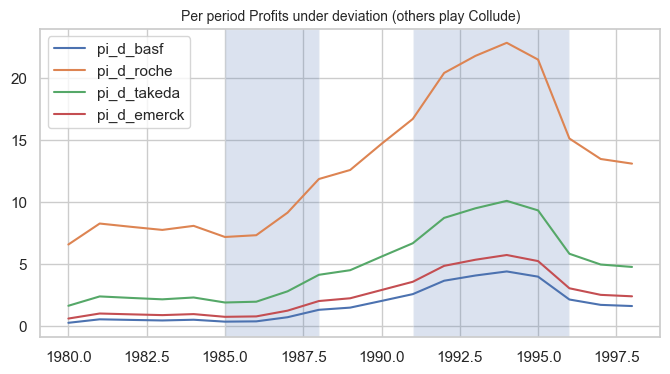

In [13]:
# profits under deviation
df['q_d_basf'] = 0.5*(alpha *df['mc_basf'] + df['eps'] - df['q_fri'] - (1-df['sh_basf'])*df['q_m'])
df['q_d_roche'] = 0.5*(alpha *df['mc_roche'] + df['eps'] - df['q_fri'] - (1-df['sh_roche'])*df['q_m'])
df['q_d_takeda'] = 0.5*(alpha *df['mc_takeda'] + df['eps'] - df['q_fri'] - (1-df['sh_takeda'])*df['q_m'])
df['q_d_emerck'] = 0.5*(alpha *df['mc_emerck'] + df['eps'] - df['q_fri'] - (1-df['sh_emerck'])*df['q_m'])
df['p_d_basf'] = 1/alpha*((1-df['sh_basf'])*df['q_m'] + df['q_d_basf'] + df['q_fri'] - df['eps'])
df['p_d_roche'] = 1/alpha*((1-df['sh_roche'])*df['q_m'] + df['q_d_roche'] + df['q_fri'] - df['eps'])
df['p_d_takeda'] = 1/alpha*((1-df['sh_takeda'])*df['q_m'] + df['q_d_takeda'] + df['q_fri'] - df['eps'])
df['p_d_emerck'] = 1/alpha*((1-df['sh_emerck'])*df['q_m'] + df['q_d_emerck'] + df['q_fri'] - df['eps'])
df['pi_d_basf'] = df['q_d_basf']*df['p_d_basf']- df['q_d_basf']*df['mc_basf']
df['pi_d_roche'] = df['q_d_roche']*df['p_d_roche']- df['q_d_roche']*df['mc_roche']
df['pi_d_takeda'] = df['q_d_takeda']*df['p_d_takeda']- df['q_d_takeda']*df['mc_takeda']
df['pi_d_emerck'] = df['q_d_emerck']*df['p_d_emerck']- df['q_d_emerck']*df['mc_emerck']
plot(['pi_d_basf','pi_d_roche','pi_d_takeda', 'pi_d_emerck'], 'Per period Profits under deviation (others play Collude)')

#### Comparative Analysis for 4 firms

- deviation gives highest profits, while competition gives lowest. 

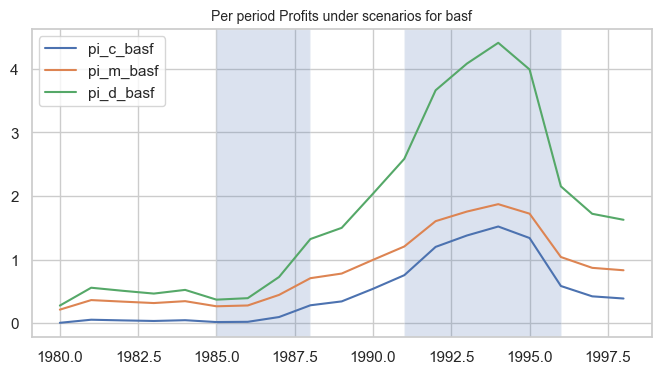

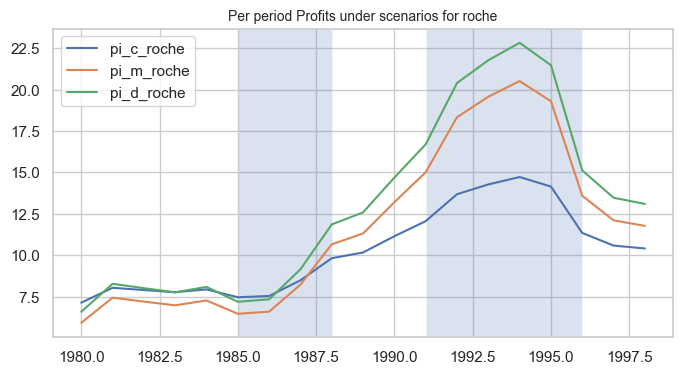

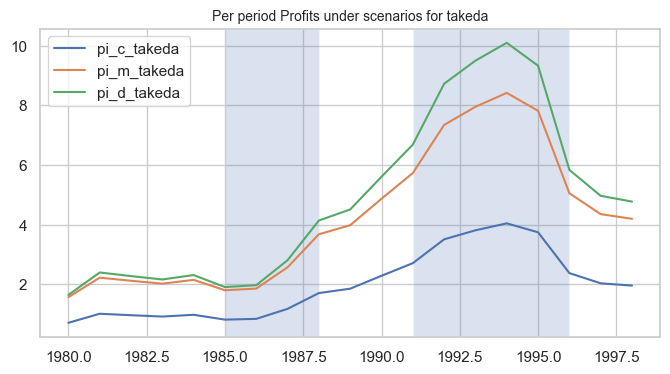

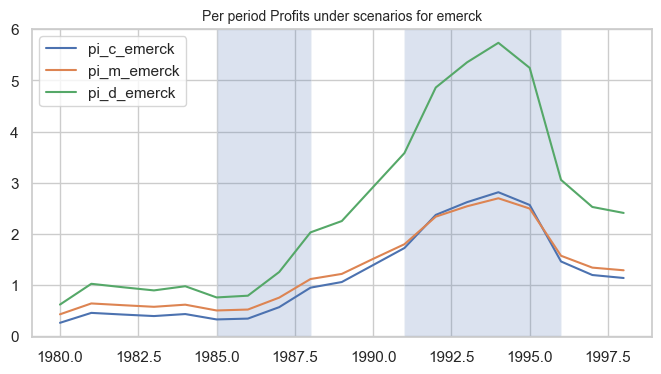

In [14]:
for name in ['basf','roche','takeda','emerck']:
    plot(['pi_c_' + name,'pi_m_' + name,'pi_d_' + name], f'Per period Profits under scenarios for {name}')

### 9) Incentive Compatibility Constraints

- for each firm i, we require at t, $\pi^m_{i,t} + \sum_{r} \delta^r \pi^m_{i,t+r} >= \pi^d_{i,t} + \sum_{r} \delta^r \pi^c_{i,t+r}$
- given profit from collusion $\pi^m_{i,t}$, profit from deviation $\pi^d_{i,t}$, and profit from competition $\pi^m_{i,t}$
- all of these are forecasts that the firm makes based on some assumptions
- assumptions in scenario 1: fringe supply and demand shifters are random walks so the best prediction for tomorrow is value that variable took today
- forecasting procedue is common for each firm and thus can be shared

### 10) Scenario 1: fringe supply constant and constant effective demand shifter

### Forecasting

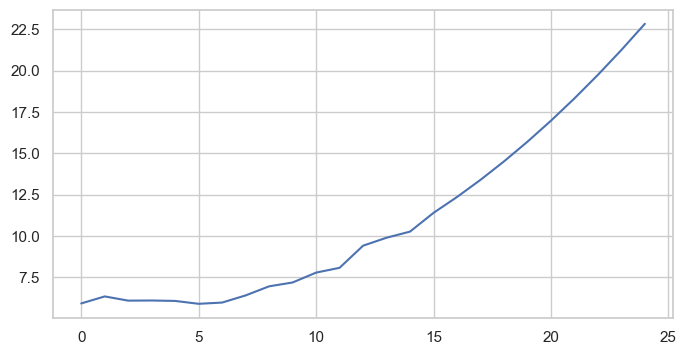

In [15]:
from sklearn.linear_model import Ridge
def ridgeForecast(var, t, f):
    y = df[df.year<t][var].to_numpy().reshape(-1,1)
    T = np.arange(1980,t).reshape(-1,1)
    x = np.c_[T,T**2,T**3]
    model = Ridge(alpha=10.0)
    T = np.arange(t,t+f).reshape(-1,1)
    x_ = np.c_[T,T**2,T**3]
    return model.fit(x,y).predict(x_)
t = 1995
plt.plot(np.r_[df.eps[df.year<t],ridgeForecast('eps', t, 10).reshape(-1)])

In [17]:
df.tail()

,year,I_cartel,P,Q,q_basf,q_emerck,q_roche,q_takeda,q_fri,mc_roche,mc_takeda,mc_emerck,mc_basf,eps,q_m,p_m,q_c_basf,q_c_roche,q_c_takeda,q_c_emerck,q_c,p_c,Q_wo_fri,pi_c_basf,pi_c_roche,pi_c_takeda,pi_c_emerck,sh_basf,sh_roche,sh_takeda,sh_emerck,q_m_basf,q_m_roche,q_m_takeda,q_m_emerck,pi_m_basf,pi_m_roche,pi_m_takeda,pi_m_emerck,q_d_basf,q_d_roche,q_d_takeda,q_d_emerck,p_d_basf,p_d_roche,p_d_takeda,p_d_emerck,pi_d_basf,pi_d_roche,pi_d_takeda,pi_d_emerck
14,1994,1,17.150833,5.19425,0.25971,0.36360,1.81799,1.09079,1.66216,5.933498,9.292948,9.907667,10.72627,10.255922,3.421314,17.526185,0.669814,2.084290,1.092826,0.911406,4.758337,12.995851,3.53209,1.520197,14.719993,4.046630,2.814591,0.080459,0.517243,0.298851,0.103448,0.275274,1.769650,1.022462,0.353928,1.871841,20.514993,8.418171,2.696407,1.141056,2.595482,1.726156,1.301179,14.592593,14.727958,15.141807,14.316546,4.411691,22.825859,10.096043,5.736740
15,1995,1,16.835833,5.51456,0.27573,0.33087,1.76466,1.04777,2.09553,5.933498,9.292948,9.907667,10.72627,10.483267,3.318301,17.177140,0.628609,2.043085,1.051621,0.870201,4.593517,12.856233,3.41903,1.338914,14.143737,3.747226,2.565846,0.080459,0.517243,0.298851,0.103448,0.266986,1.716367,0.991677,0.343272,1.722291,19.298217,7.818568,2.495404,1.085406,2.517334,1.659257,1.244344,14.404029,14.463165,14.915129,14.123969,3.991860,21.472022,9.328642,5.246533
16,1996,1,13.120833,5.65159,0.22606,0.33910,1.92154,0.96077,2.20412,5.933498,9.292948,9.907667,10.72627,9.523901,2.784323,15.367823,0.415018,1.829494,0.838030,0.656610,3.739152,12.132506,3.44747,0.583613,11.341047,2.379635,1.460852,0.080459,0.517243,0.298851,0.103448,0.224023,1.440171,0.832097,0.288033,1.039813,13.587039,5.054884,1.572703,0.796935,2.112247,1.312478,0.949736,13.426583,13.090578,13.740112,13.125726,2.151973,15.117520,5.836805,3.056306
17,1997,0,10.551667,5.81077,0.29054,0.40675,2.20809,0.98783,1.91756,5.933498,9.292948,9.907667,10.72627,8.924851,2.628078,14.838406,0.352520,1.766996,0.775532,0.594112,3.489160,11.920739,3.89321,0.421074,10.579431,2.037936,1.195991,0.080459,0.517243,0.298851,0.103448,0.211451,1.359354,0.785403,0.271869,0.869517,12.104923,4.355418,1.340517,0.712527,1.993716,1.211008,0.863532,13.140577,12.688952,13.396296,12.833634,1.720257,13.468455,4.969188,2.526665
18,1998,0,9.862500,5.91666,0.35500,0.41417,2.24833,1.00583,1.89333,5.933498,9.292948,9.907667,10.72627,8.827349,2.591442,14.714270,0.337866,1.752342,0.760878,0.579458,3.430542,11.871085,4.02333,0.386794,10.404680,1.961647,1.137718,0.080459,0.517243,0.298851,0.103448,0.208504,1.340405,0.774454,0.268079,0.831513,11.769787,4.198566,1.288552,0.692735,1.965923,1.187216,0.843319,13.073515,12.594780,13.315679,12.765145,1.626018,13.095568,4.775851,2.409765


In [16]:
from sklearn.linear_model import Ridge

def forecast(t, f, kind='myopic'):
    if kind=='myopic':
        qf_forecast = df['q_fri'][df.year==t].item()*np.ones(f)
        eps_forecast = df['eps'][df.year==t].item()*np.ones(f)      
        min_mc_forecast = df['mc_roche'][df.year==t].item()*np.ones(f)
    elif kind=='lasso':
        qf_forecast = ridgeForecast('q_fri', t, f).reshape(-1)
        eps_forecast = ridgeForecast('eps', t, f).reshape(-1)    
        min_mc_forecast = ridgeForecast('mc_roche', t, f).reshape(-1)  
    elif kind=='perfect':
        m = len(df['q_fri'][df.year>=t])
        qf_forecast = np.r_[df['q_fri'][df.year>=t], df['q_fri'][df.year==1998].item()*np.ones(f-m)]
        eps_forecast = np.r_[df['eps'][df.year>=t], df['eps'][df.year==1998].item()*np.ones(f-m)]
        min_mc_forecast = np.r_[df['mc_roche'][df.year>=t], df['mc_roche'][df.year==1998].item()*np.ones(f-m)]                          
    return qf_forecast, eps_forecast, min_mc_forecast

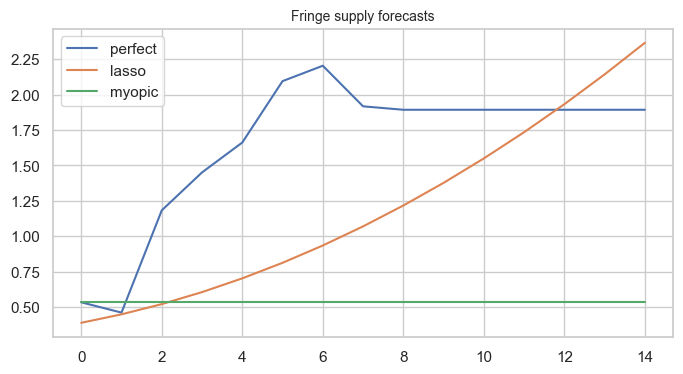

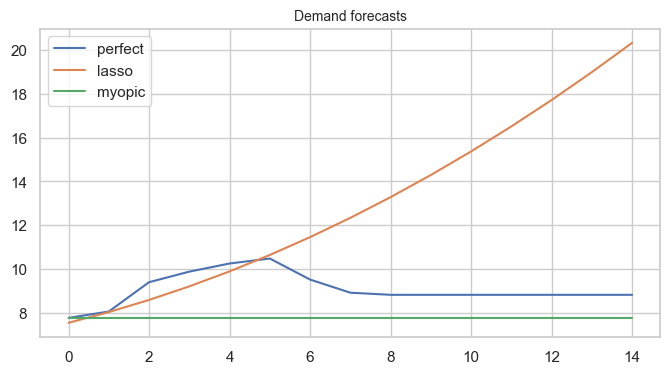

In [20]:
t = 1990
qf_forecast1, eps_forecast1, min_mc_forecast1 = forecast(t,15, 'perfect')
qf_forecast2, eps_forecast2, min_mc_forecast2 = forecast(t,15, 'lasso')
qf_forecast3, eps_forecast3, min_mc_forecast3 = forecast(t,15, 'myopic')
plt.plot(qf_forecast1, label = 'perfect')
plt.plot(qf_forecast2, label = 'lasso')
plt.plot(qf_forecast3, label = 'myopic')
plt.title('Fringe supply forecasts')
plt.legend()
plt.show()

plt.plot(eps_forecast1, label = 'perfect')
plt.plot(eps_forecast2, label = 'lasso')
plt.plot(eps_forecast3, label = 'myopic')
plt.title('Demand forecasts')
plt.legend()
plt.show()

### Forecasting Profits

In [21]:
def commonForecast(qf_forecast, eps_forecast, min_mc_forecast):
    # Collusion
    q_m = 0.5 * (eps_forecast + alpha * min_mc_forecast - qf_forecast)
    p_m = 1/alpha * (q_m+qf_forecast-eps_forecast)
    pi_ms = []
    for name in ['basf','roche','takeda','emerck']:  
        idx = 'q_' + name
        share = float(df1990[idx]/(df1990.Q-df1990.q_fri))
        idx = 'mc_' + name
        mc_firm = df[idx].iloc[0].item()
        q_m_firm = share*q_m
        pi_m_firm = q_m_firm*(p_m - mc_firm)
        pi_ms.append(list(pi_m_firm))

    # Competition
    q_c = []
    for i in range(eps_forecast.shape[0]):
        B = []
        for name in ['basf','roche','takeda','emerck']:
            idx = 'mc_' + name
            B.append(alpha * df[idx].iloc[0].item() + eps_forecast[i] - qf_forecast[i])
        B = np.array(B).reshape(-1,1)
        A = np.array([[2,1,1,1],[1,2,1,1],[1,1,2,1],[1,1,1,2]])
        q_c.append(list(np.dot(np.linalg.inv(A),B).reshape(-1)))
    q_c = np.array(q_c)
    p_c = (1/alpha)*(np.sum(q_c,axis=1)+qf_forecast-eps_forecast).reshape(-1,1)
    mc_c = df.iloc[0][['mc_basf','mc_roche','mc_takeda','mc_emerck']].to_numpy().reshape(-1)
    pi_cs = q_c*p_c-q_c*mc_c

    return pi_cs,np.array(pi_ms).T,q_m,p_m

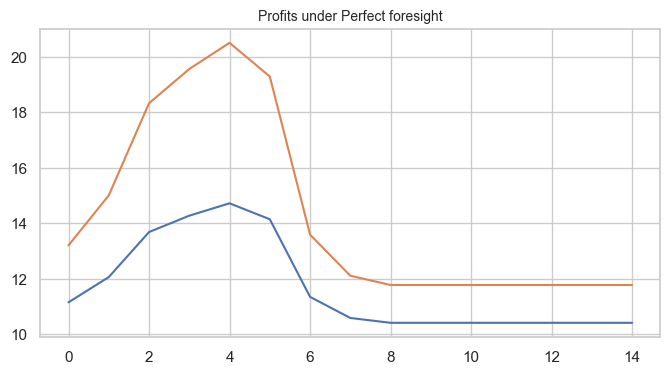

In [22]:
pi_cs, pi_ms, q_m,p_m = commonForecast(qf_forecast1, eps_forecast1, min_mc_forecast1)
plt.plot(pi_cs[:,1])
plt.plot(pi_ms[:,1])
plt.title('Profits under Perfect foresight')
plt.show()

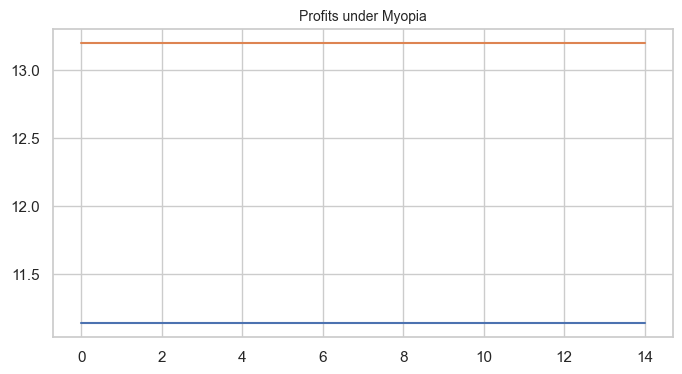

In [23]:
pi_cs, pi_ms, q_m,p_m = commonForecast(qf_forecast3, eps_forecast3, min_mc_forecast3)
plt.plot(pi_cs[:,1])
plt.plot(pi_ms[:,1])
plt.title('Profits under Myopia')
plt.show()

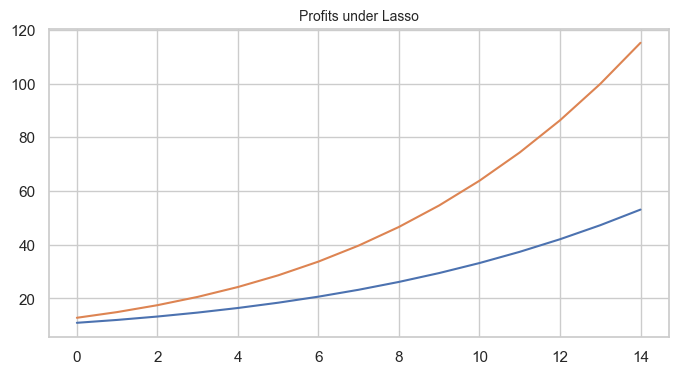

In [24]:
pi_cs, pi_ms, q_m,p_m = commonForecast(qf_forecast2, eps_forecast2, min_mc_forecast2)
plt.plot(pi_cs[:,1])
plt.plot(pi_ms[:,1])
plt.title('Profits under Lasso')
plt.show()

In [25]:
def firmSpecificForecast(name, pi_cs, pi_ms, q_m, p_m, qf_forecast, eps_forecast, min_mc_forecast):
    "Returns profits from deviation in first period of forecasted future"
    idx = 'mc_'+name
    idx2 = 'sh_'+name
    share = df[idx2].iloc[0].item()
    mc = df[idx].iloc[0].item()
    q_d = 0.5*(alpha * mc + eps_forecast[0] - qf_forecast[0] - (1-share)*q_m[0])
    p_d = 1/alpha*((1-share)*q_m[0] + q_d + qf_forecast[0] - eps_forecast[0])
    pi_d = q_d*(p_d-mc)
    return pi_d

firmSpecificForecast('basf', pi_cs, pi_ms, q_m, p_m, qf_forecast1, eps_forecast1, min_mc_forecast1)

2.13424187500509

### ICC

In [30]:
def NPV(series,discount):
    value = 0
    for ix, x in enumerate(series):
        value += x * discount ** (ix+1)
    return value

delta = 0.8
current_year = 1995
pi_c_name = 'pi_c_' + 'roche' 
NPV(df[pi_c_name][df.year>current_year],delta)   

21.170869924203025

In [38]:
ICCs = []
tmin = 1991
tmax = 1998
for t in range(1991,1998): 
    #print('\n',t)
    # Compute forecasts for fringe supply and demand
    qf_forecast, eps_forecast, min_mc_forecast = forecast(t,15,'perfect')
    print(qf_forecast.shape, eps_forecast.shape)

    # Compute projections under competition and monopoly
    pi_cs, pi_ms, q_m, p_m = commonForecast(qf_forecast, eps_forecast, min_mc_forecast)

    firm_ICC = []
    for i, name in enumerate(['basf','roche', 'takeda', 'emerck']):

        # compute profits from deviation
        pi_d = firmSpecificForecast(name, pi_cs, pi_ms, q_m, p_m, qf_forecast, eps_forecast, min_mc_forecast)

        # compute NPVs and firm-specific ICC
        A = NPV(pi_ms[1:, i] - pi_cs[1:, i], delta)
        B = pi_d - pi_ms[0,i]
        #print(name, A, B, pi_d)
        firm_ICC.append(A-B)
    #print(firm_ICC)
    ICCs.append(firm_ICC)
ICCs = np.array(ICCs)

(15,) (15,)
(15,) (15,)
(15,) (15,)
(15,) (15,)
(15,) (15,)
(15,) (15,)
(15,) (15,)


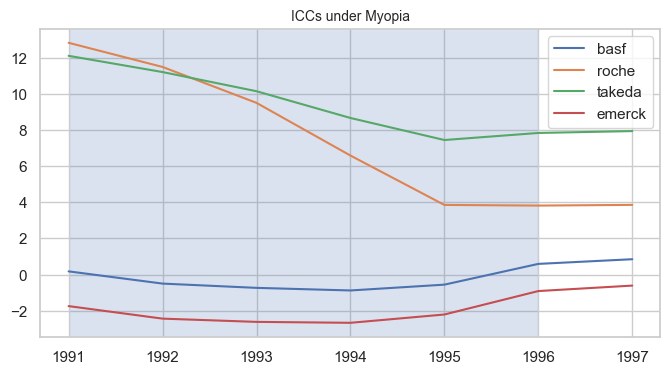

In [39]:
plt.plot(np.arange(tmin,1998), ICCs, label = ['basf','roche', 'takeda', 'emerck'])
plt.title('ICCs under Myopia') 
plt.axvspan(1991, 1996, alpha=0.2)
plt.legend()
plt.show()

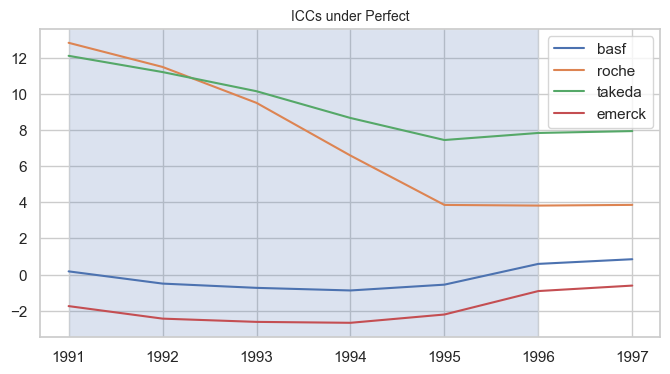

In [40]:
plt.plot(np.arange(tmin,1998), ICCs, label = ['basf','roche', 'takeda', 'emerck'])
plt.title('ICCs under Perfect') 
plt.axvspan(1991, 1996, alpha=0.2)
plt.legend()
plt.show()

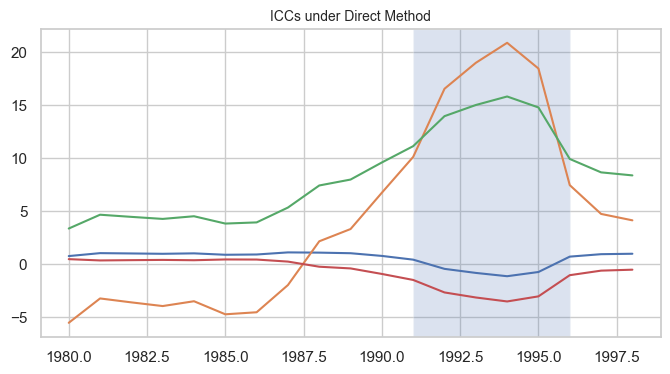

In [41]:
# Direct Method

delta = 0.8
def computeICC(x):
    current_year = int(x.year)
    mask = [df.year>current_year]
    ICCs = []
    for name in ['basf', 'roche', 'takeda','emerck']:
        pi_d_name = 'pi_d_' + name 
        pi_m_name = 'pi_m_' + name 
        pi_c_name = 'pi_c_' + name 
        next_year = current_year+1
        ICC = (delta/(1-delta))*(x[pi_m_name]-x[pi_c_name])-(x[pi_d_name]-x[pi_m_name])
        ICCs.append(ICC)
    return ICCs

df[['ICC_basf', 'ICC_roche', 'ICC_takeda','ICC_emerck']] = df.apply(computeICC, result_type='expand', axis = 1) 
plt.plot(df.year, df[['ICC_basf', 'ICC_roche', 'ICC_takeda','ICC_emerck']])
plt.title('ICCs under Direct Method') 
plt.axvspan(1991, 1996, alpha=0.2)
plt.show()

### Paper